In [154]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [5]:
dataset = pd.read_pickle("../data/all_tickers_last_decade_features.pkl")

In [6]:
dataset.shape

(869435, 27)

### Tendencia
GGAL (USD) observa una tendencia que cambia de signo a partir de principios de 2018

In [96]:
ggal_5y = dataset.loc[(dataset.Year > 2015) & (dataset.Ticker == 'GGAL'),['Adj Close']]

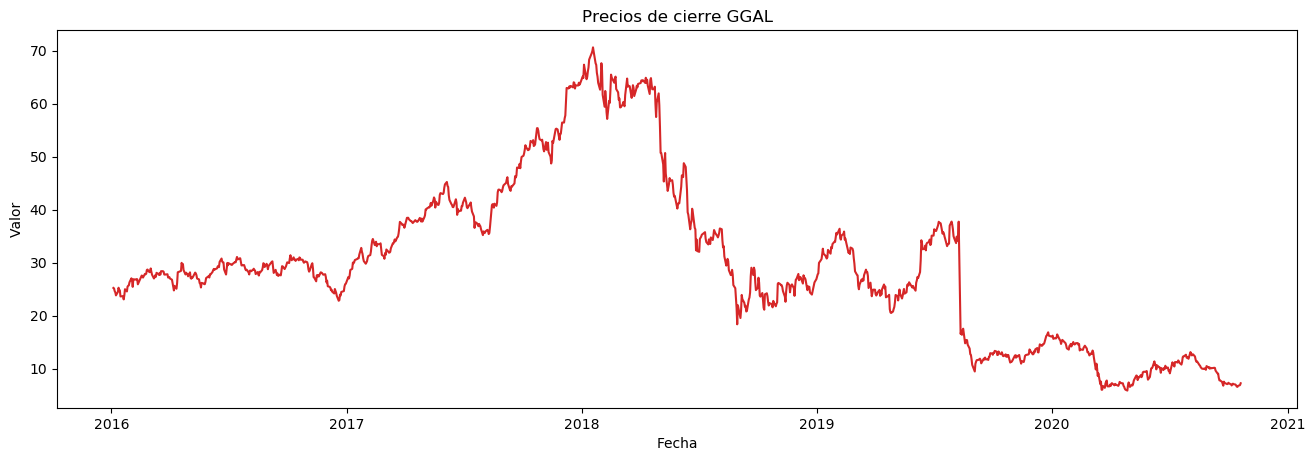

In [98]:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(ggal_5y, x=ggal_5y.index, y=ggal_5y.loc[:,'Adj Close'], title='Precios de cierre GGAL')

### Estacionalidad
GGAL (USD) no presenta estacionalidad mensual

In [100]:
# Preparamos los datos:
ggal_5y['year'] = [d.year for d in ggal_5y.index]
ggal_5y['month'] = [d.strftime('%b') for d in ggal_5y.index]
years = ggal_5y['year'].unique()

In [147]:
# ¿Cuál es el último día registrado del mes?
ggal_5y.groupby(ggal_5y.index.to_period('M')).apply(lambda x: x.index.day.max()).head(12)

Date
2016-01    29
2016-02    29
2016-03    31
2016-04    29
2016-05    31
2016-06    30
2016-07    29
2016-08    31
2016-09    30
2016-10    31
2016-11    30
2016-12    30
Freq: M, dtype: int64

In [137]:
# Precio de cierre al ultimo día registrado del mes
ggal_last = ggal_5y.iloc[ggal_5y.reset_index().groupby(ggal_5y.index.to_period('M'))['Adj Close'].idxmax()]

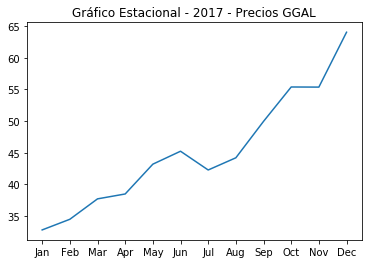

In [149]:
plt.plot('month', 'Adj Close', data=ggal_last.loc[ggal_last.year==2017, :])
plt.title("Gráfico Estacional - 2017 - Precios GGAL");
plt.show()

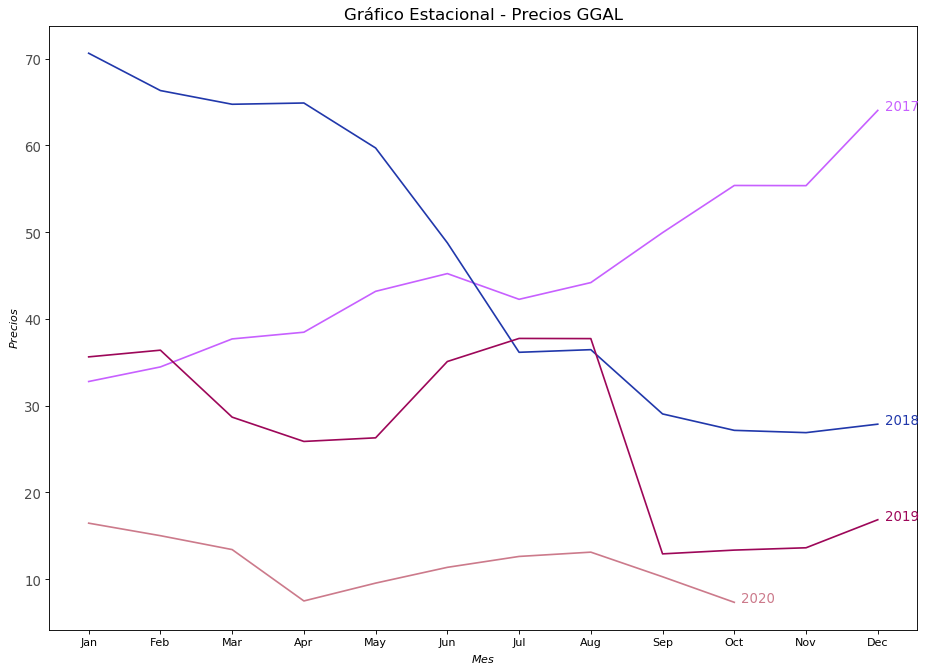

In [152]:
# Preparamos los colores:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Ploteamos
plt.figure(figsize=(14,10), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Adj Close', data=ggal_last.loc[ggal_last.year==y, :], color=mycolors[i], label=y) # grafica los 12 meses de cada año
        plt.text(ggal_last.loc[ggal_last.year==y, :].shape[0]-.9, ggal_last.loc[ggal_last.year==y, 'Adj Close'][-1:].values[0], y, fontsize=12, color=mycolors[i])


plt.gca().set(ylabel='$Precios$', xlabel='$Mes$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Gráfico Estacional - Precios GGAL", fontsize=15);

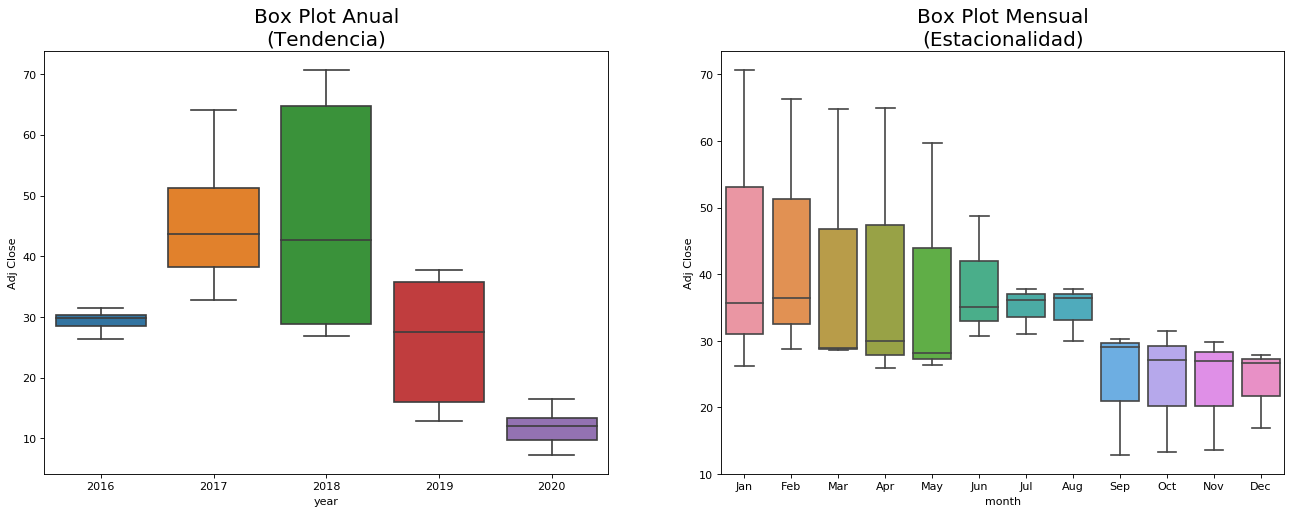

In [156]:
# Definimos los plots:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Adj Close', data=ggal_last, ax=axes[0])
sns.boxplot(x='month', y='Adj Close', data=ggal_last.loc[~ggal_last.year.isin([2017, 2020]), :])

# Seteamos los títulos:
axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18);

### Modelos

In [163]:
from sklearn.model_selection import train_test_split

In [159]:
ggal_5y["timeIndex"] = pd.Series(np.arange(len(ggal_5y['Adj Close'])), index=ggal_5y.index)

In [161]:
ggal_5y = ggal_5y.join(pd.get_dummies(ggal_5y['month'], drop_first=True), how='left')

In [162]:
ggal_5y

,Adj Close,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,
2016-01-04,25.234743,2016,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-05,25.148024,2016,Jan,1,0,0,0,1,0,0,0,0,0,0,0
2016-01-06,24.646992,2016,Jan,2,0,0,0,1,0,0,0,0,0,0,0
2016-01-07,24.396471,2016,Jan,3,0,0,0,1,0,0,0,0,0,0,0
2016-01-08,23.827993,2016,Jan,4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-14,6.610000,2020,Oct,1204,0,0,0,0,0,0,0,0,0,1,0
2020-10-15,6.560000,2020,Oct,1205,0,0,0,0,0,0,0,0,0,1,0
2020-10-16,6.760000,2020,Oct,1206,0,0,0,0,0,0,0,0,0,1,0


In [184]:
# Días registrados en el último año
len(ggal_5y.loc[ggal_5y.index.year==2020,:])

203

In [185]:
ggal_train, ggal_test = train_test_split(ggal_5y, test_size=len(ggal_5y.loc[ggal_5y.index.year==2020,:]), random_state=42, shuffle=False)

In [186]:
ggal_train.tail(3)

,Adj Close,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,
2019-12-27,16.234283,2019,Dec,1003,0,1,0,0,0,0,0,0,0,0,0
2019-12-30,16.105755,2019,Dec,1004,0,1,0,0,0,0,0,0,0,0,0
2019-12-31,16.046432,2019,Dec,1005,0,1,0,0,0,0,0,0,0,0,0


In [187]:
ggal_test.head(3)

,Adj Close,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,
2020-01-02,16.224398,2020,Jan,1006,0,0,0,1,0,0,0,0,0,0,0
2020-01-03,15.621297,2020,Jan,1007,0,0,0,1,0,0,0,0,0,0,0
2020-01-06,15.789374,2020,Jan,1008,0,0,0,1,0,0,0,0,0,0,0


#### Tendencia con transformación logarítmica

In [188]:
import statsmodels.formula.api as smf

In [200]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2 # hace broadcasting
    rmse = np.sqrt(mse.sum() / mse.count()) # suma el broadcasting
    return rmse

In [189]:
# se transforman los valores para luego entrenar el modelo

ggal_train['log_value'] = np.log(ggal_train['Adj Close'])
ggal_test['log_value'] = np.log(ggal_test['Adj Close'])

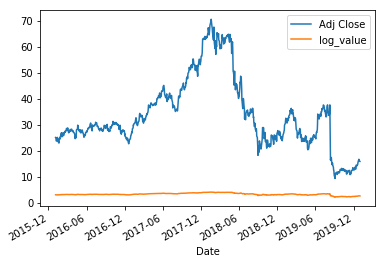

In [190]:
ggal_train.plot(kind="line", y = ['Adj Close','log_value']);

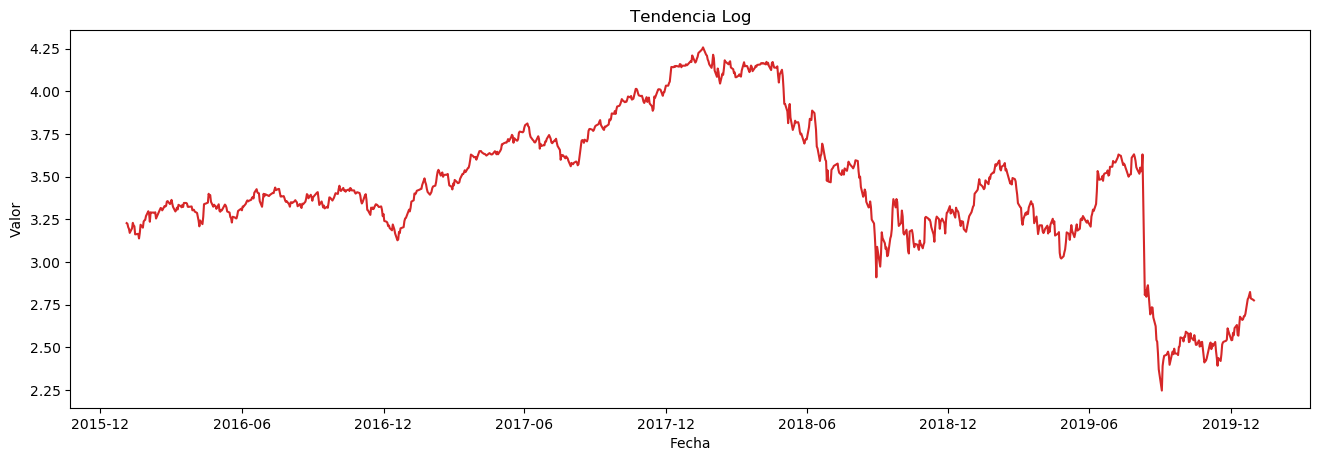

In [191]:
plot_df(ggal_train, x=ggal_train.index, y=ggal_train['log_value'], title='Tendencia Log')

In [192]:
model_log = smf.ols('log_value ~ timeIndex ', data = ggal_train).fit()

No presenta una tendencia marcada

In [193]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     102.7
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           4.86e-23
Time:                        12:51:22   Log-Likelihood:                -490.52
No. Observations:                1006   AIC:                             985.0
Df Residuals:                    1004   BIC:                             994.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6580      0.025    147.191      0.000       3.609       3.707
timeIndex     -0.0004   4.28e-05    -10.133      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       18.455   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.062
Skew:                           0.126   Prob(JB):                      0.00240
Kurtosis:                       2.526   Cond. No.                     1.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [194]:
ggal_train['model_log'] = model_log.predict(ggal_train[["timeIndex"]])
ggal_test['model_log'] = model_log.predict(ggal_test[["timeIndex"]])

In [195]:
# back-transformation
ggal_train['back_model_log'] = np.exp(ggal_train['model_log'])
ggal_test['back_model_log'] = np.exp(ggal_test['model_log'])

Train

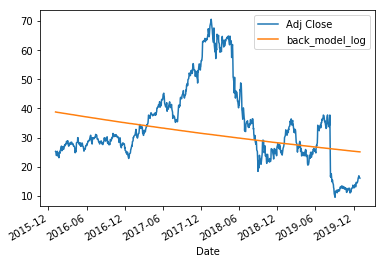

In [196]:
ggal_train.plot(kind = "line", y = ['Adj Close', 'back_model_log']);

In [202]:
RMSE(ggal_train['back_model_log'], ggal_train['Adj Close'])

13.807040793323685

Test

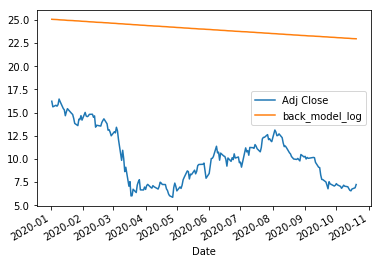

In [197]:
ggal_test.plot(kind = "line", y = ['Adj Close', 'back_model_log']);

In [201]:
RMSE(ggal_test['back_model_log'], ggal_test['Adj Close'])

14.04071130602098